# Broad institute Dataset pre-processing and cleaning 

## Import libraries

In [1]:
import os 
import glob
import sys
from collections import defaultdict
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, fcluster, ward
from scipy.spatial.distance import  squareform
import seaborn as sns
from statsmodels import robust



## Data exploration

### Load data: replicas and annotations 

- Load annotation data files
- Load replicas present in the Data/ directory into one data frame 
- Concatenate the data frames into one 

__The dataset__: 10 080 compounds came from the Molecular Libraries Small Molecule Repository (MLSMR). 2260 were drugs, natural products, and small-molecule probes that are part of the Broad Institute's known bioactive compound collection, 269 were confirmed screening hits from the Molecular Libraries Program (MLP), and 18 051 were novel compounds derived from diversity-oriented synthesis. 

1. Load the chemical annotation file, and check the 2 first line of your annotation file

*Chemical\_annotations.csv* is provided with the BBC$047$ dataset. It contains metadata on the chemical library of the screened compounds. Some compounds with the same compound name are stereoisomers. 

For example, we can find three entries for the molecule named *anabasine*, each with a different broad ID because this molecule is tested under three stereoisomers. This is important information to consider, as the generic molecule name might be the same but the SMILES differ. Therefore, when aggregating the morphological replicas under a treatment profile, we will obtain three treatment profiles for Anabasine.

In [2]:
annotations = pd.read_csv('../Data/Annotations/chemical_annotations.csv')
annotations.head(2)

,BROAD_ID,CPD_NAME,CPD_NAME_TYPE,CPD_SAMPLE_ID,DOS_LIBRARY,SOURCE_NAME,CHEMIST_NAME,VENDOR_CATALOG_ID,CPD_SMILES,USERCOMMENT
0,BRD-A56675431-001-04-0,altizide,INN,SA82748,NaN,Prestwick Chemical Inc.,NaN,Prestw-721,NS(=O)(=O)c1cc2c(NC(CSCC=C)NS2(=O)=O)cc1Cl,NaN
1,BRD-A51829654-001-01-4,"BRL-15,572",common,SA82481,NaN,Biomol International Inc.,NaN,AC-536,OC(CN1CCN(CC1)c1cccc(Cl)c1)C(c1ccccc1)c1ccccc1,NaN


In [3]:
# Exemple of Anabasine
annotations[annotations['CPD_NAME'] == 'anabasine']

,BROAD_ID,CPD_NAME,CPD_NAME_TYPE,CPD_SAMPLE_ID,DOS_LIBRARY,SOURCE_NAME,CHEMIST_NAME,VENDOR_CATALOG_ID,CPD_SMILES,USERCOMMENT
356,BRD-K94837957-003-01-4,anabasine,primary-common,SA792683,NaN,Tocris Bioscience,NaN,1971,C1CC[C@H](NC1)c1cccnc1,NaN
744,BRD-A24284985-001-02-4,anabasine,primary-common,SA62830,NaN,Sigma-Aldrich,NaN,A5656,C1CCC(NC1)c1cccnc1,NaN
1714,BRD-K36638830-001-02-2,anabasine,primary-common,SA82885,NaN,Prestwick Chemical Inc.,NaN,Prestw-669,C1CC[C@@H](NC1)c1cccnc1,NaN


We are only interested in the first two columns and the 'smiles' column. Therefore, we can drop the others.

In [4]:
desired_col = ["BROAD_ID", "CPD_NAME", "CPD_SMILES"] 
annotations = annotations.loc[:, desired_col]

# One can visualize the data after removing some metadata 
annotations.head(2)

,BROAD_ID,CPD_NAME,CPD_SMILES
0,BRD-A56675431-001-04-0,altizide,NS(=O)(=O)c1cc2c(NC(CSCC=C)NS2(=O)=O)cc1Cl
1,BRD-A51829654-001-01-4,"BRL-15,572",OC(CN1CCN(CC1)c1cccc(Cl)c1)C(c1ccccc1)c1ccccc1


2. Load the morphological profile replicas file.



The profiles are provided in several CSV files. The profiles are split into 63 files to facilitate storage.

In [5]:
path_to_pickle_file = ('../Data/Cell_Profiles')
all_profiles = glob.glob(os.path.join(path_to_pickle_file, "part_*"))

We open, read and concatenate all the files into one dataframe 

- _NB : The obtain dataframe should have 1800 columns and 153370 lines_ 
    

In [6]:
profiles = pd.concat((pd.read_csv(f) for f in all_profiles), ignore_index=True)
print(f'The dataframe has {profiles.shape[0]} lines and {profiles.shape[1]} columns')
profiles.head(2)

The dataframe has 153370 lines and 1800 columns


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_ASSAY_WELL_ROLE,Metadata_broad_sample,Metadata_mmoles_per_liter,Metadata_solvent,Metadata_pert_id,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,25692,a01,25692,C-2113-01-D39-021,a01,mock,DMSO,0.0,DMSO,NaN,...,3.757766,1.423576,1.476285,1.445165,1.642289,1.875568,1.760791,2.450487,2.348636,2.416143
1,25692,a02,25692,C-2113-01-D39-021,a02,mock,DMSO,0.0,DMSO,NaN,...,3.032794,1.374216,1.390197,1.393801,1.552905,1.686087,1.609445,2.246500,2.262934,2.316178


### Exploration
- Explores the structures and types of the data frame.
- Harmonize the dataset.
- Merge annotations (name, smiles) with morphological profile.


Once the data is loaded you can explore them using functions like :
- _.describe()_, which generates descriptive statistics 
- _.head(n=5)_, which returns the first \(n \) rows. <br>

One can also use attributes like:
- _dtypes_, which return the data type of each column.

In [7]:
pd.DataFrame({'Column': profiles.columns, 'Data_Type': profiles.dtypes})

,Column,Data_Type
Metadata_Plate,Metadata_Plate,int64
Metadata_Well,Metadata_Well,object
Metadata_Assay_Plate_Barcode,Metadata_Assay_Plate_Barcode,int64
Metadata_Plate_Map_Name,Metadata_Plate_Map_Name,object
Metadata_well_position,Metadata_well_position,object
...,...,...
Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_3_0,float64
Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_Mito_5_0,float64
Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_10_0,float64
Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_3_0,float64


1. Removing metadata features <br>
   We noticed that some metadata won't be useful, so we dropped them.


In [8]:
to_pop = ['Metadata_Well',
          'Metadata_mmoles_per_liter',
          'Metadata_Plate_Map_Name',
          'Metadata_well_position',
          'Metadata_ASSAY_WELL_ROLE',
          'Metadata_solvent',
          'Metadata_pert_id',
          'Metadata_pert_mfc_id',
          'Metadata_pert_well',
          'Metadata_cell_id',
          'Metadata_broad_sample_type',
          'Metadata_pert_vehicle',
          'Metadata_pert_type',
          'Metadata_Assay_Plate_Barcode',
          'Metadata_pert_id_vendor']

# Drop unnecessary column
profiles.drop(columns=to_pop, inplace=True)

# Move 'Metadata_broad_sample' column upfront
profiles = profiles[['Metadata_broad_sample'] + [col for col in profiles.columns if col != 'Metadata_broad_sample']]


2. Harmonization of the data 

Note that compounds are identified by _Metadata_broad_sample_ in the profile data frame, but by _BROAD_ID_ in the annotation data frame. <br>
As we intend to merge these data, we will rename the latter to _Metadata_broad_sample_. <br>
Additionally, we observed that the chemical annotation file does not include a line referring to the mock control DMSO, so we will add it to the annotation file.


In [9]:
annotations = annotations.rename(columns={"BROAD_ID":"Metadata_broad_sample"})
idx = annotations.shape[0]
annotations.loc[idx] = {'Metadata_broad_sample':'DMSO', 'CPD_NAME':'DMSO', 'CPD_SMILES':'CS(=O)C'}

annotations.reset_index(inplace=True)
annotations.drop(columns='index',inplace=True)

print(f'There are {annotations.shape[0]} rows in chemical_annotations.csv files')
print(f'There are {annotations.shape[1]} colunms in chemical_annotation.csv files')
print(f'There are {len(set(profiles.Metadata_broad_sample))} unique Metada molecule id within the Profile dataset')

There are 30617 rows in chemical_annotations.csv files
There are 3 colunms in chemical_annotation.csv files
There are 30617 unique Metada molecule id within the Profile dataset


There are the same number of compounds in both datasets. Now, we can merge them using '_Metadata_broad_sample_' as the merging feature.


3. Merge the data frames into one 

In [10]:
profiles = profiles.merge(annotations, how='left', on='Metadata_broad_sample')

# Move 'CPD_NAME' and CPD_SMILES' columns upfront 
cpd = profiles.pop('CPD_NAME')
smile = profiles.pop('CPD_SMILES')

# Concatenate columns
profiles = pd.concat([cpd, smile, profiles], axis=1)

Now our compounds can be identified in 3 ways:

- Metadata_broad_sample: the ID used by the BROAD institute to run the experiment
- CPD_NAME: The molecule compound name as it can be found in public libraries
- CPD_SMILES: The SMILES notation, which will be useful for later work


In [11]:
print(f'There are {len(set(profiles.Metadata_broad_sample))} unique Metada molecule id within this dataset')
print(f'There are {len(set(profiles.CPD_NAME))} unique compound name within this dataset')
print(f'There are {len(set(profiles.CPD_SMILES))} unique compound SMILES within this dataset')

There are 30617 unique Metada molecule id within this dataset
There are 30342 unique compound name within this dataset
There are 30410 unique compound SMILES within this dataset


## Data Inspection: Quality data check

- Removal of noisy features provided by literature.
- Identification of missing values.
- Identification of noisy features.


### Noisy Features

Way and Gregory (2019) identified a list of 55 features for removal.<br>
These features constitute the Block list Features - Cell Profiler, available on figshare [https://doi.org/10.6084/m9.figshare.10255811.v3].

1. Load and drop the Blocklist Feature 

In [12]:

path_blocklist_features = ('../Data/Annotations/blocklist_features.txt')
df_blocklist = pd.read_table(path_blocklist_features)
blocklist_features = df_blocklist['blocklist'].to_list()
profiles.drop(blocklist_features, axis=1, inplace=True)

In [13]:
print(f'There are {profiles.shape[0]} replicas for {profiles.shape[1]} features')

There are 153370 replicas for 1732 features


### Remove missing values and constant descriptors


- Check if some columns contain missing values (NaN).
  - Different ways to handle missing values (perform imputation, replace with median value, or drop them) > here, dropped.
- Remove columns with only NA.
  - The column is irrelevant.
- Remove invariant columns, where variance = 0.


1. Missing Value 

In [14]:
columns_with_nan = profiles.columns[profiles.isna().sum() > 0]
print(f'{columns_with_nan.to_list()} contains missing value.')

['CPD_NAME', 'CPD_SMILES'] contains missing value.


The "Name" is not an important feature as it can be replaced by the other identifier. However, the "Smile" identifier is crucial for later analysis.

Once we identify the number of missing treatments or missing smile information, we can either look online and download it or remove it if we consider that we are not losing valuable information.


In [15]:
size = len(set(profiles[profiles['CPD_NAME'].isna()]['Metadata_broad_sample'].to_list()))
print(f'{size} molecules are not provided with smiles, this would mean that at maximum {size*4} profiles are removed from the datase if each of this molecule are performed in quadruplicates')
print(f'There are {profiles.shape[0]} replicas for {profiles.shape[1]} features')

4 molecules are not provided with smiles, this would mean that at maximum 16 profiles are removed from the datase if each of this molecule are performed in quadruplicates
There are 153370 replicas for 1732 features


In [16]:
profiles.dropna(inplace=True)

In [17]:
print(f'There are {profiles.shape[0]} replicas after removing missing values for {profiles.shape[1]} features')
profiles.reset_index(drop=True, inplace=True)

There are 153351 replicas after removing missing values for 1732 features


2. Null or constant variance

In [18]:
constant_features = profiles.columns[np.all(profiles == profiles.iloc[0], axis=0)]
print("Constant features to be removed are:", constant_features.to_list())

Constant features to be removed are: ['Cells_AreaShape_EulerNumber', 'Cells_Children_Cytoplasm_Count', 'Nuclei_Children_Cells_Count', 'Nuclei_Children_Cytoplasm_Count']


In [19]:
profiles.drop(constant_features.to_list(), axis=1 , inplace=True)
profiles = profiles.reset_index()
profiles.drop(columns='index',inplace=True)

In [20]:
print(f'There are {profiles.shape[0]} replicas after removing null / constant variance for {profiles.shape[1]} features')

There are 153351 replicas after removing null / constant variance for 1728 features


### Experimental plates analysis

1. Batch effects

According to Caicedo et al. (https://doi.org/10.1038/nmeth.4397), batch effects can be identified by plotting the correlation between control samples (DMSO) and comparing the correlation values within a plate with the correlation to other plates. <br>
A high intra-plate correlation implies that plate effects may be present. <br>
Since our data frame is too large to plot the correlation between all controls on all plates, we drew 5 random plates without replacement to demonstrate how such a plot could be created.

In [21]:
def plot_correlation_between_DMSO_samples(plate_list: list, profiles:pd.DataFrame):
    '''
        plots the correlation between the profiles of all DMSO samples for the given plates
        
        @param: plate_list: list containing the plate IDs to consider
        @param: profiles: pd.DataFrame with the profiles
        
        @return: a heatmap plot with the correlations
    '''
    
    # we only consider DMSO samples and drop the non-feature columns from the DF
    plotting_df = profiles.loc[profiles['CPD_NAME'] == 'DMSO',:].copy(deep = True)
    plotting_df = plotting_df.drop(columns=['CPD_NAME', 'CPD_SMILES', 'Metadata_broad_sample'])
    
    # the Plate ID is set as new index because we need it later to identify batch effects for specific plates
    plotting_df = plotting_df.set_index(['Metadata_Plate', plotting_df.index])
    # only consider the plates in the given list
    plotting_df = plotting_df.loc[plate_list, :]
    # for the corr function, the df must be transposed
    plotting_df = plotting_df.transpose()
    # automatically calculates Pearson correlation between all DMSO samples for the considered plates
    corr = plotting_df.corr()
    
    # create a color palette st each plate id in the plate list is assigned to a color
    color_palette = sns.cubehelix_palette(len(plate_list),
                                        light=.6, dark=.1, reverse=True,
                                        start=1, rot=-2)
    # store the colors in a dict
    plate_ids_to_color_dict = dict(zip(map(str, plate_list), color_palette))

    # we annotate each sample with the corresponding plate color
    plot_names = {}
    for tuple_ in corr.columns:
        plot_names[tuple_] = plate_ids_to_color_dict[str(tuple_[0])]
    # and store the information in a series
    plate_and_sample_ids_to_color_series = pd.Series(plot_names)
    vmin = corr.min().min()
    center = 1 - ((1- vmin)/2)
    g = sns.clustermap(corr, cmap = 'coolwarm',
                    # center the divergin color scale at 0.9 to make batch effects mor visible
                    center = center,vmin=vmin, vmax=1,
                    # no automatic clustering
                    row_cluster=False, col_cluster=False,
                    # add colored class labels
                    row_colors=plate_and_sample_ids_to_color_series, col_colors=plate_and_sample_ids_to_color_series,
                    linewidths=0, xticklabels=False, yticklabels=False)
    ax = g.ax_heatmap
    ax.set_xlabel("")
    ax.set_ylabel("")
    # create legend with plate ids and colors
    for label in plate_list:
        label = str(label)
        g.ax_col_dendrogram.bar(0, 0, color=plate_ids_to_color_dict[label],
                                label=label, linewidth=0)
    g.ax_col_dendrogram.legend(loc="center", ncol=5, title = 'Plate ID')
    g.cax.set_position([1, .2, .03, .45])
    return g

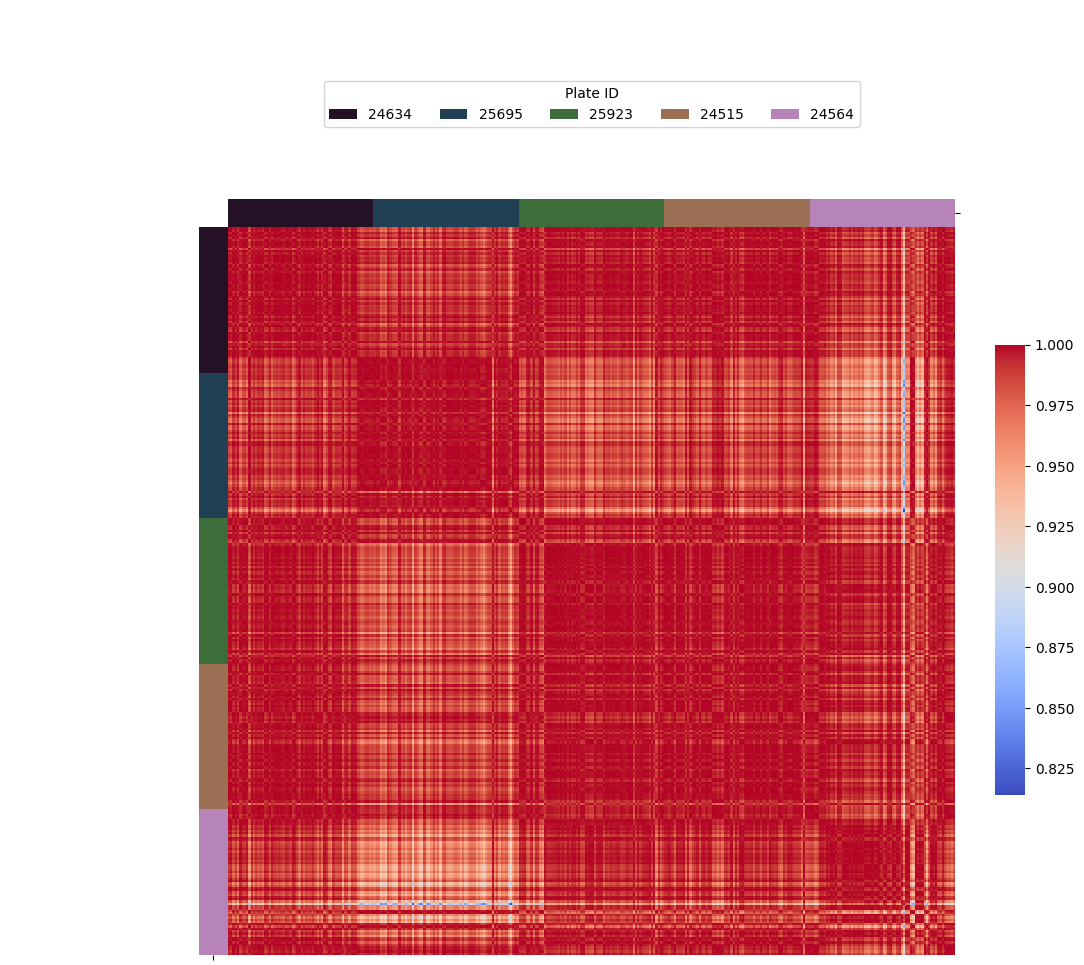

In [22]:
np.random.seed(42)
choice = np.random.choice(np.unique(profiles['Metadata_Plate'].values), size = 5, replace=False)
plot_correlation_between_DMSO_samples(plate_list=choice, profiles=profiles.copy(deep = True))

Looking at the heatmap, we obtain that the DMSO samples from plate 25695 are more correlated to themselves than to the samples from any other plate. Consequently, we suspect a batch effect for this plate and are going to remove it in the following by performing a normalization step.

### Dead cells 

High-toxicity compounds causing the death of the cells need to be identified and removed from the dataset. The feature *Number_object* or *Count_object* helps to characterize this population. It is considered that values below a certain percentage represent dead cells in comparison to DMSO profiles.

Each plate is inspected, and for every individual within the plate, their Cells_Number_Object_Number value is evaluated to determine if it is less than a certain percentage of the median DMSO value. When this condition is satisfied, the individual's name = molecule name and index are identified and subsequently removed from the dataset.

> The features *_Number_Object_Number* exist for 3 objects, Cells, Nuclei, Cytoplasm. We first check how correlated the 3 features are since they are supposed to relatively identical values.

In [23]:

nb_object_df = pd.DataFrame([profiles['Cells_Number_Object_Number'],profiles['Cytoplasm_Number_Object_Number'],profiles['Nuclei_Number_Object_Number' ]]).transpose()
nb_object_df.corr(method='pearson')

,Cells_Number_Object_Number,Cytoplasm_Number_Object_Number,Nuclei_Number_Object_Number
Cells_Number_Object_Number,1.0,1.0,1.0
Cytoplasm_Number_Object_Number,1.0,1.0,1.0
Nuclei_Number_Object_Number,1.0,1.0,1.0


The table shows that the three features are correlated with $( r = 1 $), meaning they provide the same information. Therefore, we choose one feature to continue the analysis.


1. Dead Cells identification

In [24]:
plates_list = list(set(profiles.Metadata_Plate))

In [25]:
print(f'There is {len(plates_list)} experimental plate')

There is 406 experimental plate


In [26]:

#check if there are dead cells on a plate 

def identify_dead_cells(dataset,plates_num):
    '''
    We check if there are dead cells within each plate  
    Parameters :
        dataset: pandas DataFrame with profiles
        plates_num: list containing unique plate numbers in the dataset
    Return :
         result_index: list of indices in dataset where dead cells were found
         all mols: list of compound names inducing cell death
    '''
    count = 0
    result_index, all_mols = [], []
    for plate in plates_num :

        view_Plate = dataset.loc[dataset['Metadata_Plate']== plate]
        lower_lim = round(view_Plate.loc[view_Plate['Metadata_broad_sample']=='DMSO']['Cells_Number_Object_Number'].median()*0.3)
        mol_name = view_Plate[view_Plate['Cells_Number_Object_Number'] < lower_lim]['Metadata_broad_sample'].to_list()
        
        
        to_drop = view_Plate[view_Plate['Cells_Number_Object_Number'] < lower_lim].index.values.tolist()
        result_index = [*result_index,*to_drop]
        all_mols = [*all_mols,*mol_name]
        count = count + len(to_drop)

    print(f'There are {len(set(all_mols))} unique molecules inducing death for {len(result_index)} profiles to remove' )   

    return result_index, all_mols



In [27]:
idx_dead_cells, mol_name_toxic = identify_dead_cells(profiles,plates_list)

There are 525 unique molecules inducing death for 1822 profiles to remove


2. Dead Cells removal

In [28]:
profiles.drop(labels=idx_dead_cells,inplace=True)

In [29]:
profiles.reset_index(inplace=True)
profiles.drop(columns='index',inplace=True)

In [30]:
print(f'Now, we obtain {profiles.shape[0]} profiles') 

Now, we obtain 151529 profiles



### Investigation of DMSO replicas

* Here we remove DMSO outliers by looking into DMSO's distribution of distance
* Additionally, we remove DMSOs by keeping the same ratio of DMSO per plate


In [31]:
replica_control = profiles.loc[profiles['Metadata_broad_sample'] == 'DMSO']
print(f'Dimension of control dataframe is {replica_control.shape}')
replica_control.iloc[:,3:].head(2)

Dimension of control dataframe is (26560, 1728)


,Metadata_Plate,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,25692,4128.0,346.0,253.5,1.258979,0.817046,0.568889,0.348658,99.105440,107.258866,...,3.757766,1.423576,1.476285,1.445165,1.642289,1.875568,1.760791,2.450487,2.348636,2.416143
1,25692,3680.0,375.0,270.0,1.285019,0.821609,0.541943,0.336312,95.870835,101.843016,...,3.032794,1.374216,1.390197,1.393801,1.552905,1.686087,1.609445,2.246500,2.262934,2.316178




The next lines consist in :

* Creating a data frame with the plate identifier and the corresponding DMSO ratio (i.e., number of DMSO samples by total number of samples on the plate)
* Getting the plate identifier where DMSO ratio $\geq$ 17%
* For plates with DMSO ratio $\geq$ 17%, randomly draw DMSO samples to keep s.t. after dropping the remaining replicas the ratio will be < 17%
* Keeping a ratio of 16 % DMSO per plate
* The final dataset should just contain plates with a DMSO ratio < 17% 

In [32]:
def get_ratios(data):
    '''
    get the ratio of DMSO per plate 
    number control/plate (16 % of the plates is DMSO ) ; ((384-294)*64) / 384
    '''
    ratios = {}
    list_plates = list(set(data['Metadata_Plate']))
    
    for plate in list_plates :
        if plate not in ratios : 
            ratios[plate] = round((data[ (data['Metadata_Plate'] == plate ) & (data['Metadata_broad_sample'] == 'DMSO') ].shape[0]) / (data[data['Metadata_Plate'] == plate].shape[0]),3)
    
    df_ratios = pd.DataFrame.from_dict(ratios,orient='index',columns=['Ratio_DMSO'])
    df_ratios['Ratio_DMSO'] = df_ratios['Ratio_DMSO'] * 100
    df_ratios['Metadata_Plate'] = list_plates
    return df_ratios

In [33]:
df_ratios = get_ratios(profiles)

In [34]:
df = pd.DataFrame(data={'plates': list(replica_control['Metadata_Plate'].value_counts().index), 'nb':list(replica_control['Metadata_Plate'].value_counts())})
plate_id_to_check= df_ratios[ (df_ratios['Ratio_DMSO'] >= 17 )]['Metadata_Plate'].to_list()

In [35]:
df_ratios_check = get_ratios(profiles)
plates_num_to_study = df_ratios_check[ (df_ratios['Ratio_DMSO'] >= 17 )]['Metadata_Plate'].to_list()

In [36]:
def to_keep(plates_num, all_data, control_dataset):
    '''
    Lower the ratios of DMSO per plate to < 17%
    Resampling the control per plate to a ratio (< 17%), for plates having more than 17% control samples
        Parameters : 
            plates_num (list): identifier of plates with a high number of DMSO
            all_data (data frame): all profiles 
            control_dataset (data frame): DMSO only profiles
        Returns : 
            appended_data (list) : DMSO profiles to keep 
    '''
    appended_data = []
    for nb in plates_num:
        nb_profiles = all_data[all_data['Metadata_Plate'] == nb].shape[0]
        nb_control = all_data[(all_data['Metadata_Plate'] == nb) & (
            all_data['Metadata_broad_sample'] == 'DMSO')].shape[0]
        # we use int() to always round down, which ensures ratios strictly smaller 17% 
        a = int(0.166 * (nb_profiles - nb_control))
        # we randomly draw without replacement many DMSO replicas
        keep = control_dataset.loc[control_dataset['Metadata_Plate'] == nb].sample(
            n=a, random_state=101)
        appended_data.append(keep)
    return appended_data


appended_data = to_keep(plates_num_to_study, profiles, replica_control)
control_to_keep = pd.concat(appended_data)

For the plates with a DMSO ratio $\geq$ 17%, we calculate the number of DMSO replicas needed to have a ratio < 17% and randomly draw this amount without replacement from the DMSO replicas list per plate. Now, we have to drop all other DMSO replicas.

In [37]:
replicas = profiles.copy(deep=True)

# first, we drop all DMSO samples for the plates with a DMSO ratio >= 17
for plate in plate_id_to_check:
    replicas.drop(replicas[ (replicas['Metadata_Plate'] == plate ) & (replicas['Metadata_broad_sample'] == 'DMSO') ].index,inplace=True)

# then, we append the DMSO replicas that were selected to be kept in the step above
replicas_t = pd.concat([replicas,control_to_keep])

# then, we output again the ratios to check whether everything worked
ratios_replicas = get_ratios(replicas_t) 
ratios_replicas.sort_values(axis=0,by='Ratio_DMSO',ascending=False)


,Ratio_DMSO,Metadata_Plate
25553,16.9,25553
25418,16.9,25418
25579,16.9,25579
25403,16.9,25403
26166,16.9,26166
...,...,...
25742,13.6,25742
26569,13.3,26569
26575,13.3,26575
26564,13.2,26564


In [38]:
profiles = replicas_t.copy(deep=True)

In [39]:
print(f'Now, we have obtained {profiles.shape[0]} profiles for {profiles.shape[1]} features') 

Now, we have obtained 148723 profiles for 1728 features


Now, we dropped all surplus DMSO plates. As shown in the table above, the highest DMSO ratio is 16.9%, which is strictly smaller than 17%, i.e., everything seemed to work as intended. 

## Feature normalization


### Modified Z-Score

The modified Z-score is a variation of the traditional Z-score that is more robust to outliers. While the classic Z-score is calculated using the mean and standard deviation of a dataset, the modified Z-score uses the median and median absolute deviation (MAD) instead. Modified Z-score is a robust measure of how many standard deviations a data point is from the median of the DMSO, providing a more stable measure of deviation from the central tendency in the presence of outliers.

$$
\text{Z-score} = \frac{{0.6745(X - \text{Median})}}{{\text{MAD}} }
$$

where \( X \) is the value of the data point, Median is the median of the DMSO, and MAD is the median absolute deviation.


$0.6745$ is used to make the modified Z-score comparable to the traditional Z-score under a normal distribution. Specifically, $0.6745$ is the $75$ th percentile of the standard normal distribution. Including this constant scales the modified Z-score such that it behaves similarly to a traditional Z-score, where values beyond ± $3$ are considered outliers. [ISSN 2411-2518](http://www.ss-pub.org/wp-content/uploads/2019/09/JMSS18122402.pdf)


In [40]:
def progress_bar(index, total, label):
    n_bar = 50  
    progress = index / total
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * progress):{n_bar}s}] {int(100 * progress)}%  {label}")
    sys.stdout.flush()

def fragment_data(dataset,num):
    '''
    Fragment the initial data frame into plate batches 
        
        Parameters : 
            dataset(data frame): Profiles 
            num(list): Plate identifer 
        
        Returns    :
            list_df(list): Plates (profiles) contained within a list 
    '''
    list_df = [dataset.loc[dataset['Metadata_Plate']== int(nb)].copy(deep = True) for nb in num ]
    return list_df 

def center_plate(dataset,num):
    '''
    Scaling data with a z-score scaler
        
        Parameters : 
            dataset(data frame): Profiles 
            num(list): Plate identifer 
        
        Returns    :
            l_df   : Updated plates (profiles) contain within a list 
    '''
    
    l_df = fragment_data(dataset,num)
    
    tot=len(num)
    
    for n in range(0,tot):
        progress_bar(n+1,tot,"of z-score scaling")
        non_numerical_columns = ['CPD_NAME', 'Metadata_Plate', 'Metadata_broad_sample', 'CPD_SMILES']
        dmso_samples = l_df[n]['CPD_NAME']== 'DMSO'
        z_score_scaler = lambda df: df.apply(lambda x: 0.6745 * (x - np.median(x[dmso_samples]))/(robust.mad(x[dmso_samples])), axis = 0)

        l_df[n].update(z_score_scaler(l_df[n].loc[:,np.isin(l_df[n].columns, non_numerical_columns, invert=True)].copy(deep=True))) 
    return l_df


In [41]:
l_scaled_data = center_plate(profiles,plates_list)
z_score_normalized_profiles = pd.concat(l_scaled_data, ignore_index=True)

[==================================================] 100%  of z-score scaling

In [42]:
z_score_normalized_profiles

,CPD_NAME,CPD_SMILES,Metadata_broad_sample,Metadata_Plate,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,BRD-K08693008,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1...,BRD-K08693008-001-01-9,26625,0.194558,2.245678,0.887694,1.338011,0.469587,-1.429582,...,-0.501584,0.431716,0.104300,0.062050,-1.157481,-1.691174,-1.494616,-3.797852,-2.297265,-3.485839
1,BRD-K63982890,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1N...,BRD-K63982890-001-01-9,26625,-0.611467,0.967965,0.332885,0.656038,0.128832,-1.241745,...,0.707202,-0.149489,0.229137,0.319637,-1.299579,-1.599268,-1.315596,-3.321370,-2.329740,-2.711753
2,BRD-K41006887,OC[C@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1N...,BRD-K41006887-001-01-9,26625,-0.669981,-0.406545,0.643578,0.447221,0.424424,-1.506430,...,-0.354968,-0.265360,-0.589601,-0.418861,-1.054597,-1.276550,-1.084313,-2.375513,-1.961837,-2.373245
3,BRD-K06226868,OC[C@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1NC...,BRD-K06226868-001-01-9,26625,-1.435046,-0.948605,0.865502,-0.341050,0.019907,-0.570506,...,-0.240923,-0.392675,-0.325411,-0.201060,-1.429533,-1.439733,-1.370764,1.932904,2.069048,1.869685
4,BRD-K80296876,OC[C@@H]1O[C@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1N...,BRD-K80296876-001-01-1,26625,-0.386921,-0.271030,0.421655,0.262538,0.048475,-0.535698,...,1.720557,-0.055126,0.251558,0.232693,-1.269467,-1.458190,-1.187561,6.895028,5.532099,6.070539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148718,BRD-K98444789,C[C@H](NC(=O)C[C@H]1O[C@@H](CO)[C@H](NC(=O)c2c...,BRD-K98444789-001-01-3,26623,0.253794,-0.446962,-1.247425,-0.059427,-0.182670,0.111112,...,0.409373,-1.085519,-0.927900,-1.024430,0.256024,0.725119,0.740527,0.887314,1.109370,1.316310
148719,BRD-K24284160,C[C@@H](NC(=O)C[C@H]1O[C@@H](CO)[C@H](NC(=O)c2...,BRD-K24284160-001-01-1,26623,0.046359,-0.782183,-0.719104,0.002483,-0.048729,0.961461,...,0.093135,-0.835791,-0.832768,-0.934157,0.863520,1.175049,0.963499,0.302125,0.209429,0.014751
148720,BRD-K34258713,OC[C@H]1O[C@H](CCNC(=O)c2cnccn2)CC[C@H]1NC(=O)...,BRD-K34258713-001-01-5,26623,-0.082503,-0.718332,-1.805098,0.864011,0.501790,-0.351963,...,0.166724,-0.637013,-0.528784,-0.473840,-0.357391,-0.217694,-0.460837,0.012270,0.004938,0.230649
148721,BRD-K71881549,OC[C@@H]1O[C@@H](CCNC(=O)c2cnccn2)CC[C@@H]1NC(...,BRD-K71881549-001-01-8,26623,0.173648,-1.628218,-1.482235,0.694315,0.329162,-1.100651,...,-0.443380,-0.739326,-1.018589,-0.914005,0.001178,0.143457,0.174453,0.568023,0.075617,0.346957


In [43]:
z_score_normalized_profiles[z_score_normalized_profiles['CPD_NAME']=='DMSO'].head()

,CPD_NAME,CPD_SMILES,Metadata_broad_sample,Metadata_Plate,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
12,DMSO,CS(=O)C,DMSO,26625,1.487709,-0.174234,1.087426,1.401991,1.068688,-1.593653,...,0.042118,0.490471,0.022729,0.316911,-0.043165,-0.367933,-0.391914,-0.402644,-1.235442,-1.127576
13,DMSO,CS(=O)C,DMSO,26625,2.780859,-0.987324,0.244116,0.138251,-0.378118,-0.148823,...,-0.427191,0.722687,0.501450,0.617976,0.771681,0.418365,0.451254,0.096386,-0.801806,-0.722426
36,DMSO,CS(=O)C,DMSO,26625,-0.915007,-0.445264,0.532617,-1.243313,-1.350197,0.680392,...,-0.602700,-0.436642,-0.644934,-0.497803,0.838619,0.815550,0.739649,-0.626735,-0.489899,-0.444292
37,DMSO,CS(=O)C,DMSO,26625,-0.282328,1.355150,-0.532617,0.672394,0.635401,-0.309637,...,0.548225,0.282178,0.352321,0.409184,0.065948,0.000987,0.070851,-0.450918,-0.212773,-0.062173
58,DMSO,CS(=O)C,DMSO,26625,0.362784,-0.212952,1.264964,-0.047446,-0.179210,-0.511178,...,0.005857,0.464740,0.346780,0.514916,-0.765076,-0.979687,-0.696729,-2.748393,-3.028329,-3.067719


After normalization, we look for infinite values and null values that might have been introduced during normalizing.

In [44]:
# Check for nan values
if np.isnan(z_score_normalized_profiles.iloc[0:,4:]).any().any():
    print("DataFrame contains nan values.")
else:
    print("DataFrame does not contain nan values.")

DataFrame does not contain nan values.


In [45]:
# Check for infinite values
if np.isinf(z_score_normalized_profiles.iloc[0:,4:]).any().any():
    print("DataFrame contains infinite values.")
else:
    print("DataFrame does not contain infinite values.")

DataFrame contains infinite values.


In [46]:
# drop infinite values
to_drop = []
for column in z_score_normalized_profiles.columns:
    if not column in ['CPD_NAME', 'Metadata_Plate', 'Metadata_broad_sample', 'CPD_SMILES']:
        if not np.isinf(z_score_normalized_profiles[column]).values.sum() == 0:
            to_drop.append(column)
print(f'There are {len(to_drop)} features with infinite values, which we are going to drop.')

There are 244 features with infinite values, which we are going to drop.


In [47]:
z_score_normalized_profiles.drop(to_drop, axis='columns', inplace=True)
print(f'Scaled data dimension : {z_score_normalized_profiles.shape }')

Scaled data dimension : (148723, 1484)


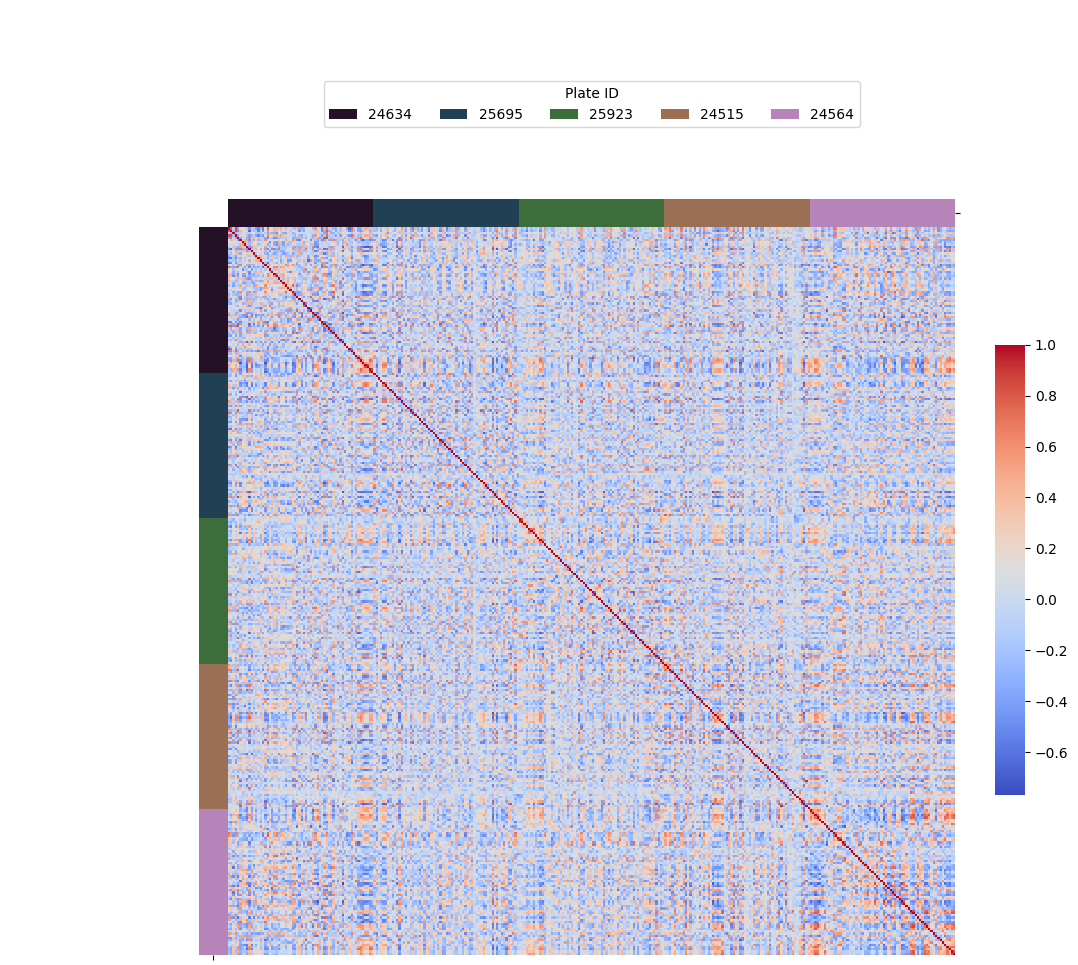

In [48]:
plot_correlation_between_DMSO_samples(plate_list=choice, profiles=z_score_normalized_profiles.copy(deep = True))

We obtain low correlations between the DMSO samples of the selected plates from above indicating that our normalization removed the batch effects.

##  Aggregation 


After scaling the data, we collapse all replicas from one compound into one unique median morphological profile.

In [49]:
print(f'There are {len(set(z_score_normalized_profiles.Metadata_broad_sample))} unique Metada molecule id within this dataset')
print(f'There are {len(set(z_score_normalized_profiles.CPD_NAME))} unique compound name within this dataset')
print(f'There are {len(set(z_score_normalized_profiles.CPD_SMILES))} unique compound SMILES within this dataset')

There are 30377 unique Metada molecule id within this dataset
There are 30112 unique compound name within this dataset
There are 30177 unique compound SMILES within this dataset


We are using Metadata molecule ID to merge the replicas into treatment profiles because 

In [50]:
z_score_agreg = z_score_normalized_profiles.groupby(['Metadata_broad_sample'],sort=False,dropna=True).median(numeric_only=True).reset_index()
z_score_agreg.drop(labels='Metadata_Plate',axis=1,inplace=True)
z_score_agreg = z_score_agreg.dropna(axis = "columns", how = 'any')

We need to keep the CPD_NAMES and CPD_SMILES for the next part.

In [51]:
z_score_agreg = annotations.merge(z_score_agreg, how='right', on='Metadata_broad_sample')
z_score_agreg.head(2)

,Metadata_broad_sample,CPD_NAME,CPD_SMILES,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,BRD-K08693008-001-01-9,BRD-K08693008,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1...,0.048557,1.511709,0.671319,1.608394,0.722371,-1.506780,-0.511233,...,1.475748,0.789284,0.581063,0.593838,-0.522194,-1.079944,-0.853066,-1.089536,-0.518401,-1.060966
1,BRD-K63982890-001-01-9,BRD-K63982890,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1N...,-0.452500,0.951801,0.099539,0.742502,0.514596,-0.919183,-0.953422,...,1.505304,0.184114,0.560507,0.595905,-1.211533,-1.462659,-1.355924,-1.750324,-1.566650,-1.867406


In [52]:
print(f'After aggragation the treatment replicas into one tratment profiles, we obtained a treatment level profiles for {z_score_agreg.shape[0]} molecules')
z_score_agreg.tail(2)

After aggragation the treatment replicas into one tratment profiles, we obtained a treatment level profiles for 30377 molecules


,Metadata_broad_sample,CPD_NAME,CPD_SMILES,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
30375,BRD-K39179354-001-01-2,BRD-K39179354,C[C@@H](CO)N1C[C@H](C)[C@H](CN(C)C(=O)Nc2ccc3O...,1.691393,1.283951,0.18051,3.631666,2.311593,-1.388961,-0.387562,...,0.477603,0.405962,0.784297,0.837130,-1.563311,-1.886362,-1.780762,-0.742678,-0.976945,-0.634140
30376,BRD-K39192716-001-01-8,BRD-K39192716,CNC[C@@H]1OCCCC[C@H](C)Oc2ccc(NS(=O)(=O)c3ccc(...,1.964437,1.438126,-0.81418,4.742255,2.744224,-1.876821,-1.040586,...,1.042592,-0.043634,0.231789,0.275195,-1.332363,-1.111941,-1.138342,-0.332081,-0.684528,-0.563528


We check and remove any constant features that might have appeared after normalization or aggregation 

In [53]:
constant_features = []
constant_features = z_score_agreg.columns[np.all(z_score_agreg == z_score_agreg.iloc[0], axis=0)]
print("Constant features to be removed are:", constant_features.to_list())

z_score_agreg.drop(constant_features.to_list(), axis=1 , inplace=True)
z_score_agreg = z_score_agreg.reset_index()
z_score_agreg.drop(columns='index',inplace=True)

Constant features to be removed are: []


### Dimensionality reduction 

This part consists of reducing the collinearity between features using Pearson correlation and a minimal redundancy and maximal relevance algorithm.

1. Reduce colinearity 

In [54]:
z_score_agreg.copy(deep = True)

,Metadata_broad_sample,CPD_NAME,CPD_SMILES,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,BRD-K08693008-001-01-9,BRD-K08693008,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1...,0.048557,1.511709,0.671319,1.608394,0.722371,-1.506780,-0.511233,...,1.475748,0.789284,0.581063,0.593838,-0.522194,-1.079944,-0.853066,-1.089536,-0.518401,-1.060966
1,BRD-K63982890-001-01-9,BRD-K63982890,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1N...,-0.452500,0.951801,0.099539,0.742502,0.514596,-0.919183,-0.953422,...,1.505304,0.184114,0.560507,0.595905,-1.211533,-1.462659,-1.355924,-1.750324,-1.566650,-1.867406
2,BRD-K41006887-001-01-9,BRD-K41006887,OC[C@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1N...,-0.057587,1.049713,0.849848,1.010894,0.752042,-0.987506,0.477231,...,1.486518,-0.010077,-0.145917,-0.112240,-0.679669,-1.089173,-0.901829,-0.620214,-0.624395,-0.616461
3,BRD-K06226868-001-01-9,BRD-K06226868,OC[C@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1NC...,-0.479606,-0.420357,0.579939,-0.186316,-0.053779,-0.499765,0.066921,...,1.070735,0.036772,-0.024177,0.147013,-1.474887,-1.500366,-1.485136,0.611448,0.241858,0.481326
4,BRD-K80296876-001-01-1,BRD-K80296876,OC[C@@H]1O[C@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1N...,-0.640939,-0.311107,0.639009,-0.391117,-0.174559,0.278100,-0.171688,...,1.271385,-0.022274,0.029658,0.046946,0.386313,0.252594,0.274163,0.864977,1.270241,1.030378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30372,BRD-K39052671-001-01-7,BRD-K39052671,C[C@@H](CO)N1C[C@@H](C)[C@@H](CN(C)C(=O)c2cccc...,1.697123,0.727416,-0.210448,3.026279,2.282505,-1.190292,-0.316087,...,0.348865,-0.269956,-0.345899,-0.320147,-1.659953,-1.450576,-1.416899,-0.116009,-0.162763,-0.000462
30373,BRD-K39090122-001-01-2,BRD-K39090122,C[C@H](CO)N1C[C@H](C)[C@@H](CN(C)C(=O)CCCN(C)C...,1.791323,0.782974,0.516024,2.203866,1.454268,-1.037064,0.017211,...,0.244379,-0.105993,-0.081132,-0.212469,-0.885128,-0.936630,-1.037801,0.068895,-0.038373,0.059196
30374,BRD-K39107553-001-01-2,BRD-K39107553,C[C@H](CO)N1C[C@H](C)[C@H](CN(C)Cc2ccncc2)OCCC...,2.075832,0.292569,-0.468804,2.050723,1.817222,-1.485533,-0.735744,...,0.676348,0.159038,-0.059095,-0.004509,-0.697472,-0.649712,-0.761140,0.218060,0.018312,0.036784
30375,BRD-K39179354-001-01-2,BRD-K39179354,C[C@@H](CO)N1C[C@H](C)[C@H](CN(C)C(=O)Nc2ccc3O...,1.691393,1.283951,0.180510,3.631666,2.311593,-1.388961,-0.387562,...,0.477603,0.405962,0.784297,0.837130,-1.563311,-1.886362,-1.780762,-0.742678,-0.976945,-0.634140


In [55]:
profiles = z_score_agreg.copy(deep = True)
data = profiles.iloc[:,3:]

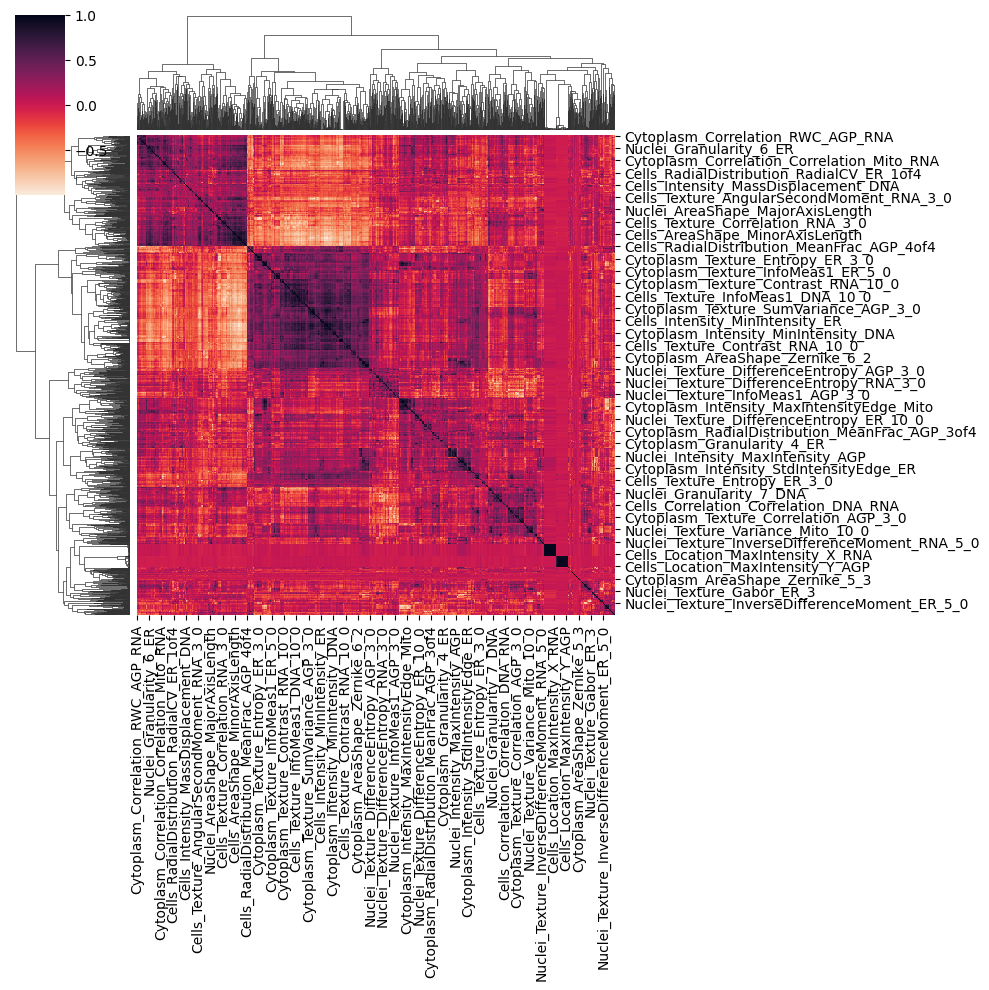

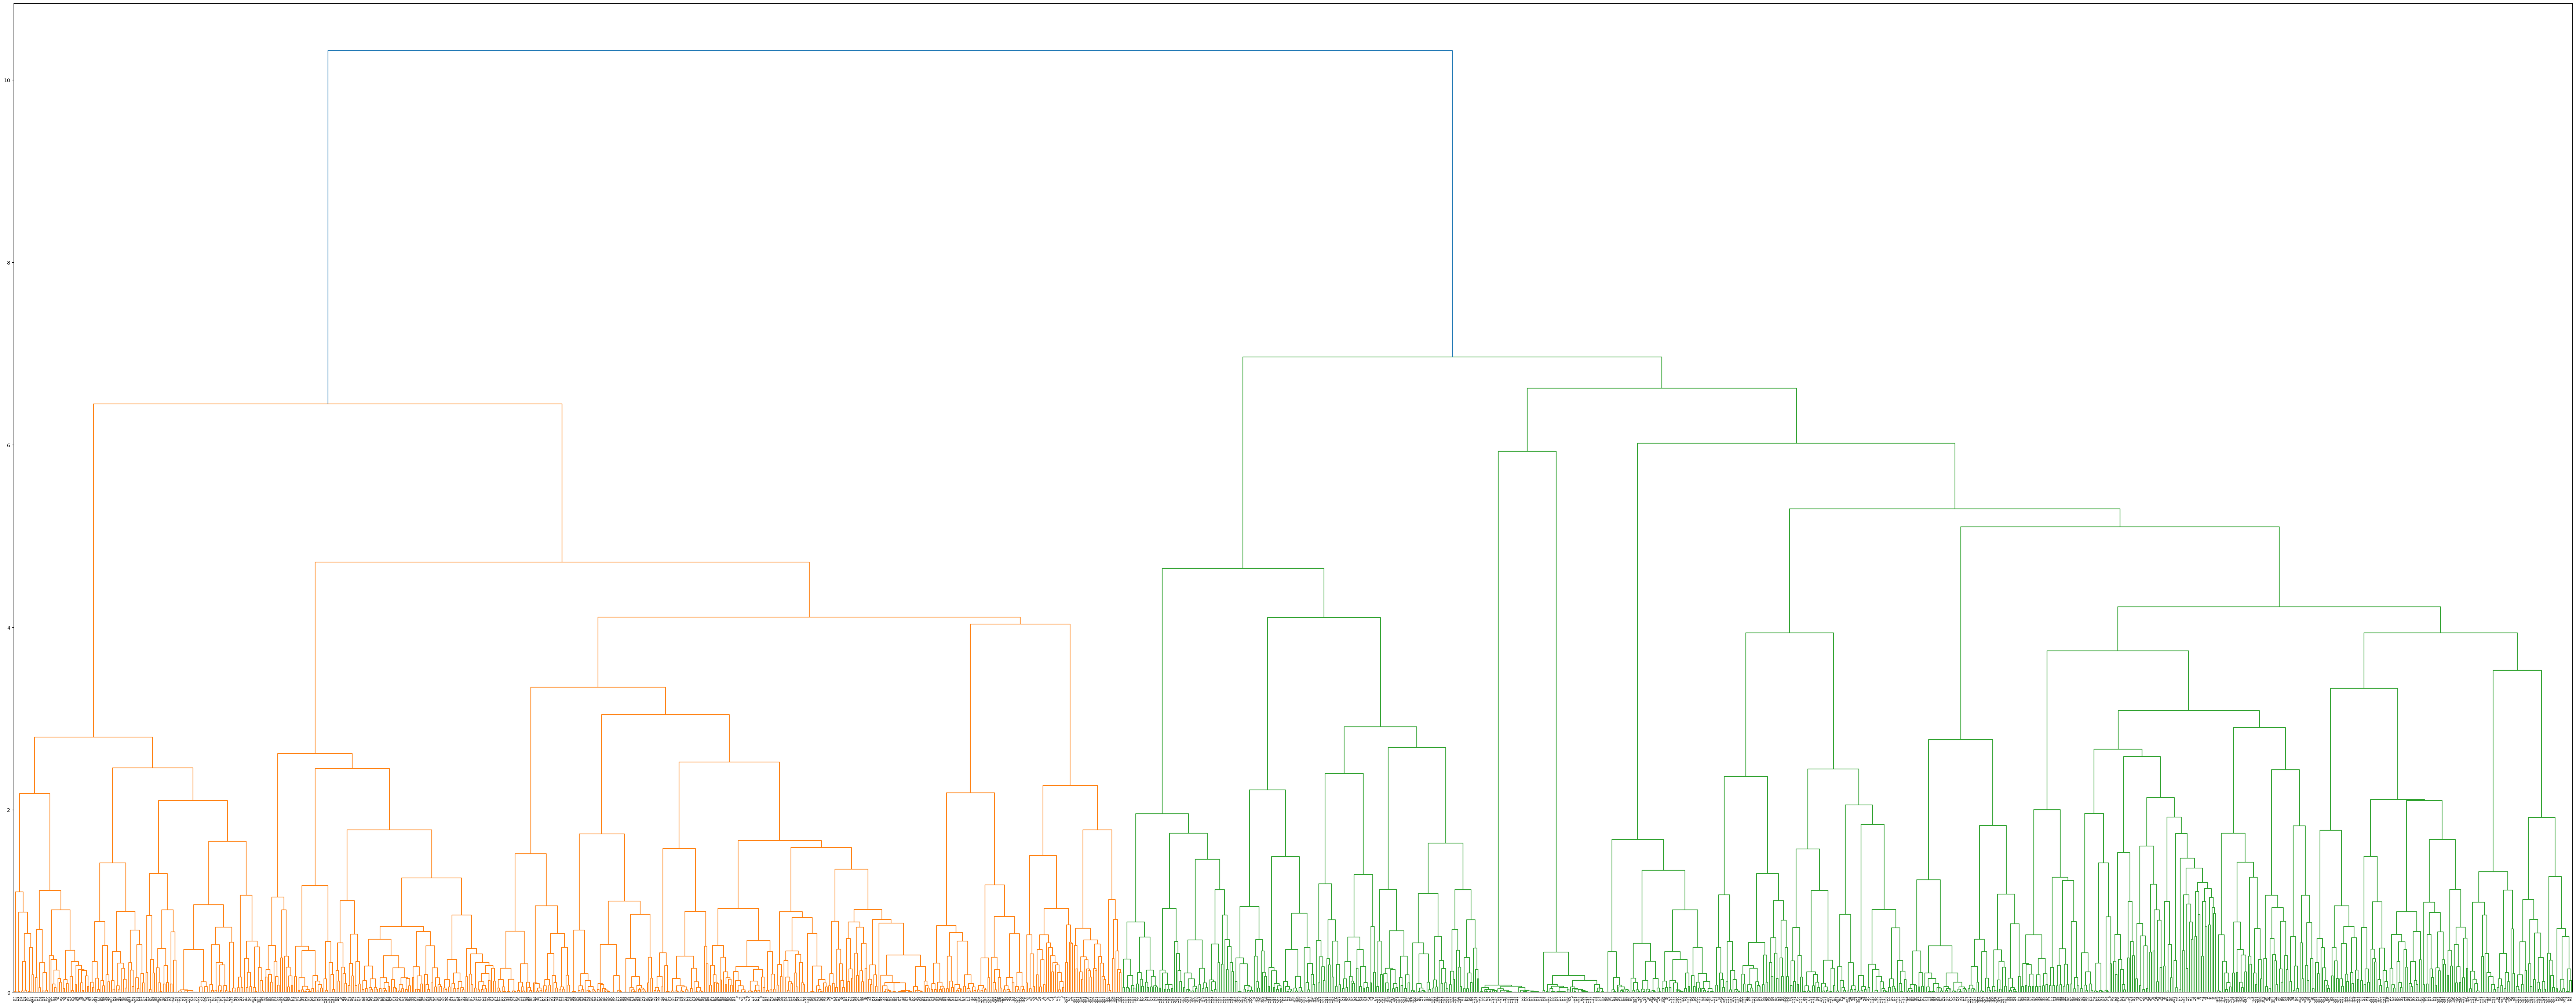

In [56]:
warnings.filterwarnings('ignore')
corr = data.corr(numeric_only=True)
sns_plot = sns.clustermap(corr, cmap="rocket_r")

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = ward(squareform(distance_matrix))

fig = plt.figure(figsize=(90, 35))
dn = dendrogram(dist_linkage)
plt.show()


Here we want to identify the optimal number of feature clusters. This means the number of clusters having a minimized intra-variance and separate the features into most distinct classes.

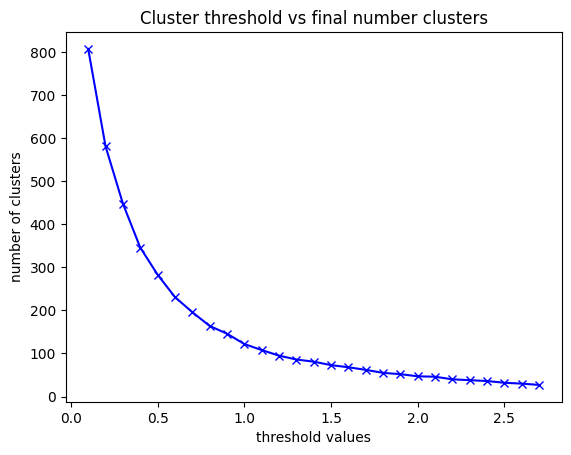

In [57]:

ts = []
num_clusters = []
for t in np.arange(0.1, 2.8, 0.10):
    ts.append(t)
    cluster_ids = fcluster(dist_linkage,t = t, criterion="distance") 
    cluster_id_to_feature_ids = defaultdict(list)

    #create a dictionary for each cluster and add features index as value  
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    
    num_clusters.append(len(cluster_id_to_feature_ids.keys()))


plt.plot(ts, num_clusters, 'bx-')
plt.xlabel('threshold values')
plt.ylabel('number of clusters')
plt.title('Cluster threshold vs final number clusters')
plt.show()


From each cluster of features, we take one feature as representative to avoid redundancy, i.e., the number of clusters is the same as the final number of selected features. The plot shows us this number versus the threshold. So, we can use it to choose the optimum threshold for our desired number of features. We choose a threshold of 0.49 since we guess that a number of features around 300 may be appropriate for our data. However, it should be noted that the `best' number of features depend on the data and the further processing. Thus, the number of features can also be tuned.

In [58]:
cluster_ids = fcluster(dist_linkage,t = 0.49, criterion="distance") 
cluster_id_to_feature_ids = defaultdict(list)

#create a dictionary for each cluster and add features index as value  
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [59]:
selected_features_names = data.columns[selected_features]
print(f'{len(selected_features_names)} features are kept')

289 features are kept


In [60]:
aggregated_profiles = pd.concat([profiles.iloc[:,:3],profiles[selected_features_names]],axis=1)

## Pickle final Data 

In [61]:
#check if directory exist before creating it
directory = '../Data/Output'
if not os.path.exists(directory):
    os.mkdir(directory)


In [62]:
aggregated_profiles.to_pickle("../Data/Output/output_notebook_1.pkl")

## Conclusion

In [63]:
print(f'After different steps of pre-processing, we obtained a treatment level profiles for {aggregated_profiles.shape[0]} molecules')
print(f'Each treatment-level profiles has {aggregated_profiles.shape[1]} features')

After different steps of pre-processing, we obtained a treatment level profiles for 30377 molecules
Each treatment-level profiles has 292 features
